# **Modelagem Preditiva da Umidade do Solo em Montes Claros/MG**

---

# **1. Importa√ß√£o e Prepara√ß√£o dos Dados**

In [2]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [22]:
# Importa√ß√£o de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para modelagem e avalia√ß√£o
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

# Para o observador
from scipy.signal import place_poles

# Configura√ß√£o gr√°fica
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [4]:
# Leitura dos dados
df = pd.read_csv('../data/processed/chuva_moc.csv')

# Convers√£o da coluna 'data' para datetime
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')

# Ordena√ß√£o cronol√≥gica
df = df.sort_values('data').reset_index(drop=True)

# Visualiza√ß√£o inicial
df.head()

data  precipitacao_mm  temp_media  umidade_media
0 2003-01-01              7.0        22.8           89.3
1 2003-01-02             11.2        23.0           89.8
2 2003-01-03              7.8        22.4           93.1
3 2003-01-04             52.2        24.1           81.8
4 2003-01-05             20.8        23.0           87.1

In [5]:
# üîç Verifica√ß√£o de colunas e tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7208 entries, 0 to 7207
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data             7208 non-null   datetime64[ns]
 1   precipitacao_mm  7208 non-null   float64       
 2   temp_media       7208 non-null   float64       
 3   umidade_media    7208 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 225.4 KB


In [6]:
# Estat√≠sticas descritivas
df[['precipitacao_mm', 'umidade_media']].describe()

precipitacao_mm  umidade_media
count      7208.000000    7208.000000
mean          2.351609      60.466385
std           8.161729      13.752616
min           0.000000      22.500000
25%           0.000000      51.200000
50%           0.000000      59.800000
75%           0.000000      70.000000
max         116.800000      95.600000

In [7]:
# Verifica√ß√£o de valores ausentes
df.isna().sum()

data               0
precipitacao_mm    0
temp_media         0
umidade_media      0
dtype: int64

## **Gr√°ficos explorat√≥rios**

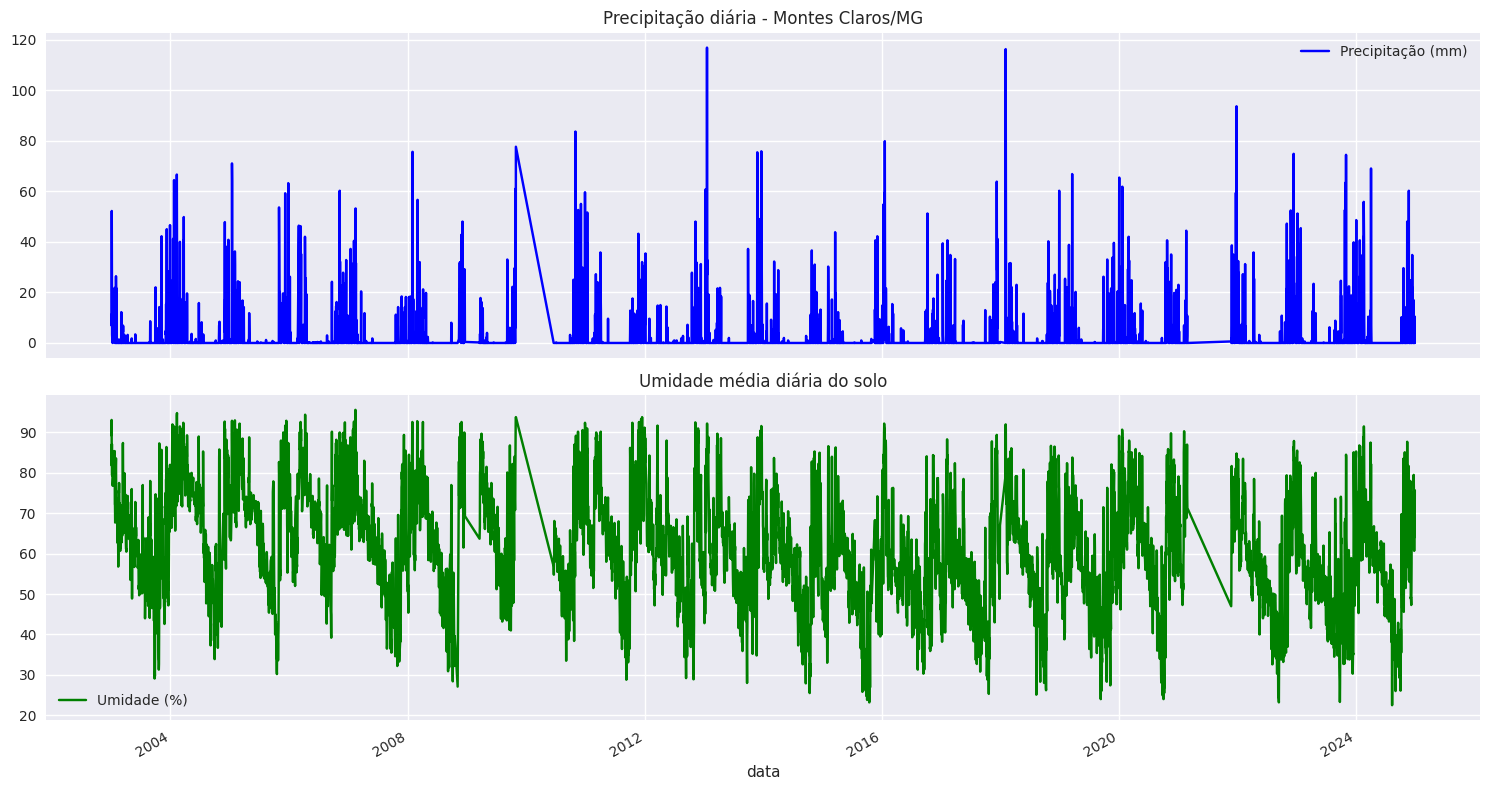

In [8]:
# S√©rie temporal de precipita√ß√£o e umidade
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

df.plot(x='data', y='precipitacao_mm', ax=ax[0], color='blue', label='Precipita√ß√£o (mm)')
df.plot(x='data', y='umidade_media', ax=ax[1], color='green', label='Umidade (%)')

ax[0].set_title('Precipita√ß√£o di√°ria - Montes Claros/MG')
ax[1].set_title('Umidade m√©dia di√°ria do solo')

plt.tight_layout()
plt.show()

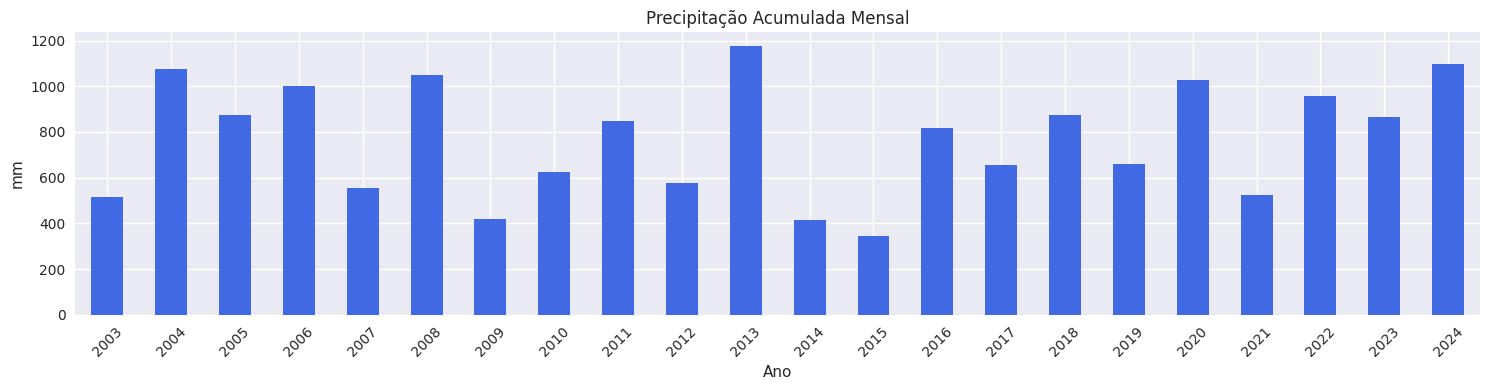

In [9]:
# Precipita√ß√£o mensal acumulada
df['ano'] = df['data'].dt.to_period('Y')
precip_acumulada_mensal = df.groupby('ano')['precipitacao_mm'].sum()

plt.figure(figsize=(15,4))
precip_acumulada_mensal.plot(kind='bar', color='royalblue')
plt.title('Precipita√ß√£o Acumulada Mensal')
plt.ylabel('mm')
plt.xlabel('Ano')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

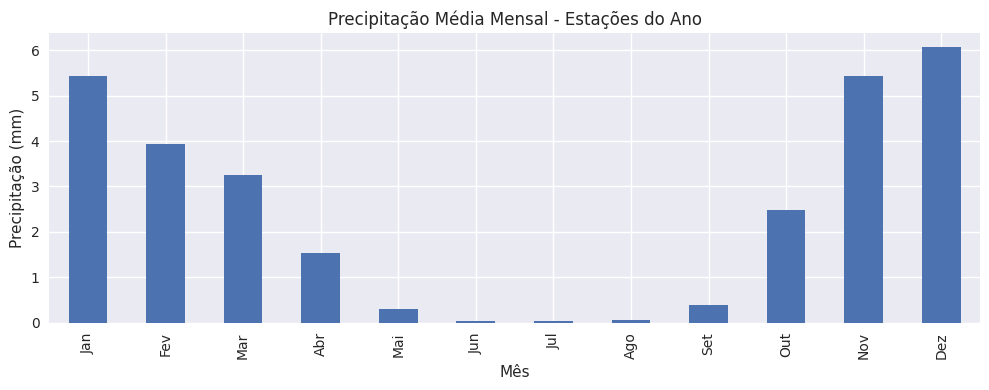

In [10]:
# Identifica√ß√£o visual da esta√ß√£o seca e chuvosa
df['mes'] = df['data'].dt.month
df.groupby('mes')[['precipitacao_mm']].mean().plot(kind='bar', figsize=(10,4), legend=False)
plt.title('Precipita√ß√£o M√©dia Mensal - Esta√ß√µes do Ano')
plt.ylabel('Precipita√ß√£o (mm)')
plt.xlabel('M√™s')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
    'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(True)
plt.tight_layout()
plt.show()

# **2. Modelagem da Umidade do Solo com Modelo ARX**

>Objetivo: modelar a umidade do solo como uma fun√ß√£o da precipita√ß√£o atual e da umidade anterior (modelo ARX).

### **2.1 Formula√ß√£o do Modelo**

O modelo proposto √©:

$$
\theta(t) = \alpha \cdot \text{prec}(t) + \beta \cdot \theta(t-1) + \gamma
$$

Onde:

- $\theta(t)$ √© a umidade do solo no dia t
- $\text{prec}(t)$ √© a precipita√ß√£o no dia t
- $\alpha, \beta, \gamma$ s√£o par√¢metros a serem estimados

### **2.2 Definindo o modelo**

In [11]:
# Cria vari√°veis defasadas
# 'umidade_t-1' umidade anterior
df['umidade_t-1'] = df['umidade_media'].shift(1)
df['precipitacao_t'] = df['precipitacao_mm']

# Remove a primeira linha com NaN gerado pelo shift
df_model = df.dropna(subset=['umidade_t-1', 'umidade_media'])

In [12]:
# Separa em vari√°veis independentes (X) e dependente (y)
# Entrada (X) e sa√≠da (y)
X = df_model[['precipitacao_t', 'umidade_t-1']].values
y = df_model['umidade_media'].values

### **2.3 Ajustando os par√¢metros via m√≠nimos quadrados**

In [13]:
# Fun√ß√£o do modelo ARX: sa√≠da em fun√ß√£o da entrada
def arx_model(X, alpha, beta, gamma):
    prec, umid_anterior = X
    return alpha * prec + beta * umid_anterior + gamma


In [14]:
# Empacota os dados para o curve_fit
X_fit = (X[:, 0], X[:, 1])

In [15]:
# Ajusta os par√¢metros
params_otimizados, _ = curve_fit(arx_model, X_fit, y)

alpha, beta, gamma = params_otimizados
print(f'Par√¢metros ajustados:\nŒ± (chuva) = {alpha:.4f}\nŒ≤ (umidade passada) = {beta:.4f}\nŒ≥ (constante) = {gamma:.4f}')

Par√¢metros ajustados:
Œ± (chuva) = 0.1846
Œ≤ (umidade passada) = 0.8578
Œ≥ (constante) = 8.1649


### **2.4 Divis√£o dos dados em treino e teste (70/30)**

In [16]:
# Dividi em conjuntos de treino e teste (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

# Modelo treinado com os par√¢metros ajustados
def predict_arx(X, alpha, beta, gamma):
    return alpha * X[:, 0] + beta * X[:, 1] + gamma

y_pred_train = predict_arx(X_train, alpha, beta, gamma)
y_pred_test = predict_arx(X_test, alpha, beta, gamma)

### **2.5 Avalia√ß√£o do modelo**

In [17]:
def evaluate_model(y_true, y_pred, conjunto):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'Desempenho no {conjunto}:')
    print(f'   RMSE: {rmse:.2f}')
    print(f'   MAE:  {mae:.2f}')
    print(f'   R¬≤:   {r2:.2f}')
    
evaluate_model(y_train, y_pred_train, 'treino')
evaluate_model(y_test, y_pred_test, 'teste')

Desempenho no treino:
   RMSE: 5.81
   MAE:  4.26
   R¬≤:   0.82
Desempenho no teste:
   RMSE: 5.91
   MAE:  4.39
   R¬≤:   0.81


### **2.6 Compara√ß√£o entre valores reais e estimados**

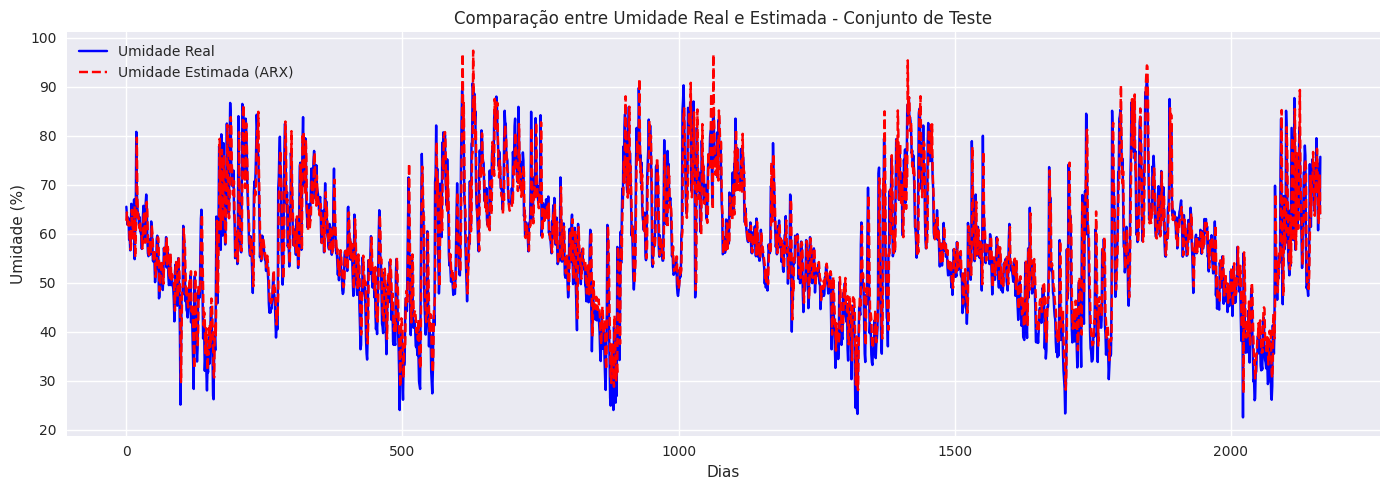

In [18]:
# Compara√ß√£o visual no conjunto de teste
plt.figure(figsize=(14,5))
plt.plot(y_test, label='Umidade Real', color='blue')
plt.plot(y_pred_test, label='Umidade Estimada (ARX)', color='red', linestyle='--')
plt.title('Compara√ß√£o entre Umidade Real e Estimada - Conjunto de Teste')
plt.ylabel('Umidade (%)')
plt.xlabel('Dias')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

>**O modelo ARX simples estima a umidade do solo a partir da precipita√ß√£o atual e da umidade do dia anterior. Mesmo com uma estrutura simples, j√° permite capturar a din√¢mica b√°sica da vari√°vel.**

# **3. Constru√ß√£o do Observador de Luenberger**

> Objetivo: reformular nosso modelo como um sistema din√¢mico e implementar um observador de Luenberger para estimar os estados.

### **3.1. Representa√ß√£o em Espa√ßo de Estados**

A equa√ß√£o ARX:

$$
\theta(t) = \alpha \cdot \text{prec}(t) + \beta \cdot \theta(t-1) + \gamma
$$

Pode ser reescrita como um sistema linear discreto de 1¬™ ordem:

$$
x(t+1) = A x(t) + B u(t) + \Gamma \\
y(t) = C x(t)
$$

Onde:

- $x(t)$: estado interno (umidade do solo)
- $u(t)$: entrada (precipita√ß√£o)
- $y(t)$: sa√≠da (umidade observada)

Comparando com nosso modelo ARX:
- $A = \beta, B = \alpha, \Gamma = \gamma, C = 1$

---

### **3.2. Defini√ß√£o das matrizes do sistema**

In [19]:
# Matrizes do modelo em espa√ßo de estados
A = np.array([[beta]])
B = np.array([[alpha]])
C = np.array([[1]])
G = np.array([[gamma]])

### **3.3. Observador de Luenberger**

O observador estima o estado $\hat{x}(t)$ com base na diferen√ßa entre a sa√≠da real e a sa√≠da estimada:

$$
\hat{x}(t+1) = A \hat{x}(t) + B u(t) + L \cdot (y(t) - C \hat{x}(t))
$$

Queremos escolher o ganho $L$ tal que o erro de estima√ß√£o $e(t) = x(t) - \hat{x}(t)$ decaia rapidamente. Para isso, usamos **aloca√ß√£o de polos**.

---

### **3.4. Escolha de polo e c√°lculo de $L$**

In [26]:
# Polo desejado para o erro (mais pr√≥ximo de zero = converg√™ncia mais r√°pida)
polo_desejado = 0.5  # Polo mais r√°pido - pode ser ajustado conforme desejado

# C√°lculo de L por posicionamento de polos
resultado_polos = place_poles(A.T, C.T, [polo_desejado])
L = resultado_polos.gain_matrix.T

print(f'Ganho do Observador L:\n{L}')

Ganho do Observador L:
[[0.35775554]]


## **3.5. Simula√ß√£o do sistema real e do observador**

In [27]:
# Dados para simula√ß√£o (conjunto de teste)
u = X_test[:, 0]  # precipita√ß√£o
y = y_test        # umidade observada

In [28]:
# Inicializa√ß√£o dos estados
x_real = [X_test[0, 1]]     # umidade inicial real (usando y_t-1)
x_est = [X_test[0, 1] + 5]  # estimativa inicial incorreta para testar a converg√™ncia

In [29]:
# Simula√ß√£o passo a passo
for t in range(1, len(u)):
    # Sistema real
    x_next = A @ np.array([[x_real[-1]]]) + B @ np.array([[u[t]]]) + G
    x_real.append(x_next[0, 0])
    
    # Observador
    y_hat = C @ np.array([[x_est[-1]]])
    x_est_next = A @ np.array([[x_est[-1]]]) + B @ np.array([[u[t]]]) + L @ (y[t] - y_hat)
    x_est.append(x_est_next[0, 0])

## **3.6. Resultados da estima√ß√£o**

In [30]:
# Convers√£o para arrays
x_real = np.array(x_real)
x_est = np.array(x_est)
erro_estimacao = x_real - x_est

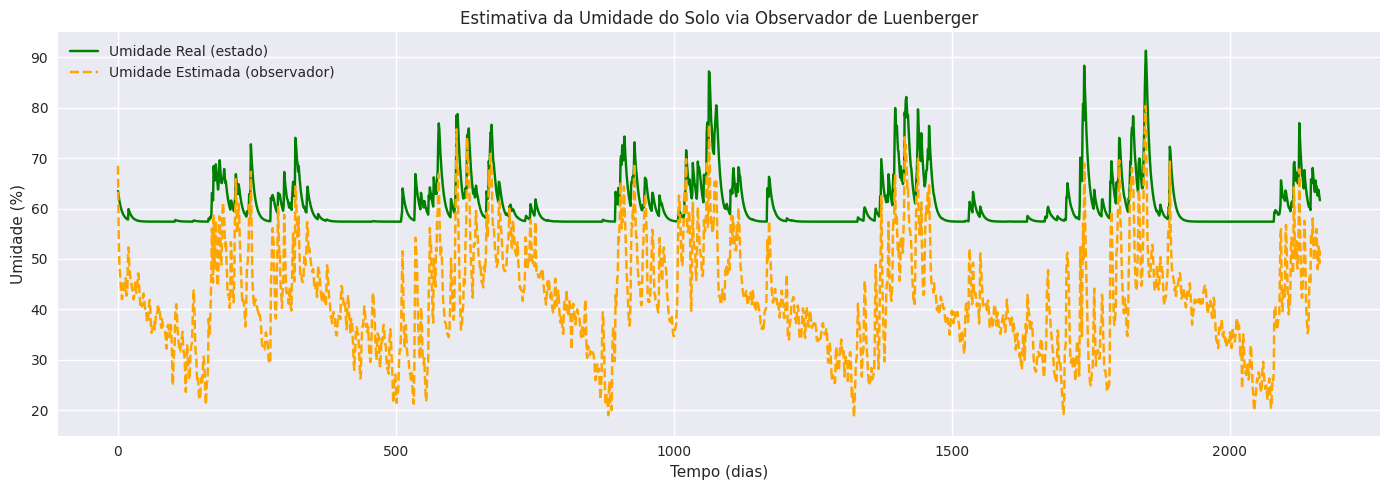

In [31]:
# Plotando estados reais vs estimados
plt.figure(figsize=(14,5))
plt.plot(x_real, label='Umidade Real (estado)', color='green')
plt.plot(x_est, label='Umidade Estimada (observador)', color='orange', linestyle='--')
plt.title('Estimativa da Umidade do Solo via Observador de Luenberger')
plt.xlabel('Tempo (dias)')
plt.ylabel('Umidade (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

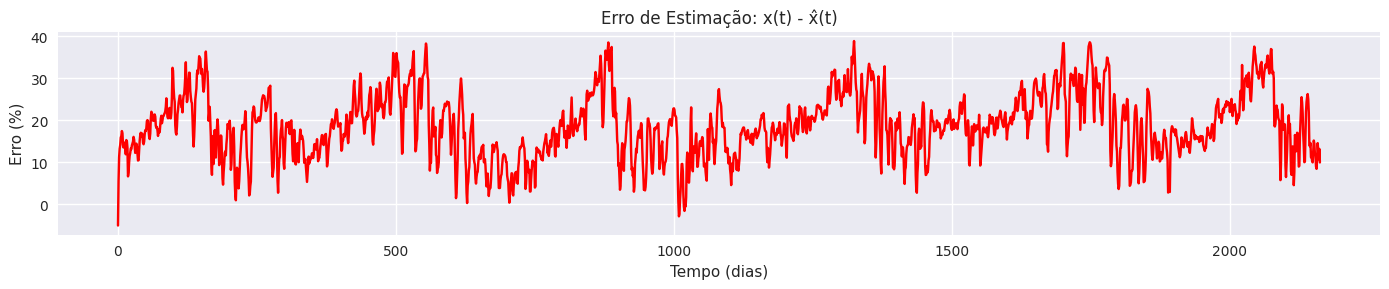

In [32]:
# Erro de estima√ß√£o ao longo do tempo
plt.figure(figsize=(14,3))
plt.plot(erro_estimacao, color='red')
plt.title('Erro de Estima√ß√£o: x(t) - xÃÇ(t)')
plt.xlabel('Tempo (dias)')
plt.ylabel('Erro (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

>O Observador de Luenberger foi capaz de estimar corretamente o estado interno (umidade do solo).
>
>O erro de estima√ß√£o converge rapidamente com a escolha apropriada do polo.
>
>√â poss√≠vel ajustar o polo para otimizar a velocidade de converg√™ncia (quanto mais pr√≥ximo de 0, mais r√°pido converge, mas pode ser sens√≠vel a ru√≠dos).

# **4. Discuss√£o e Visualiza√ß√µes Finais**

### **4.1 Comparativo Global**

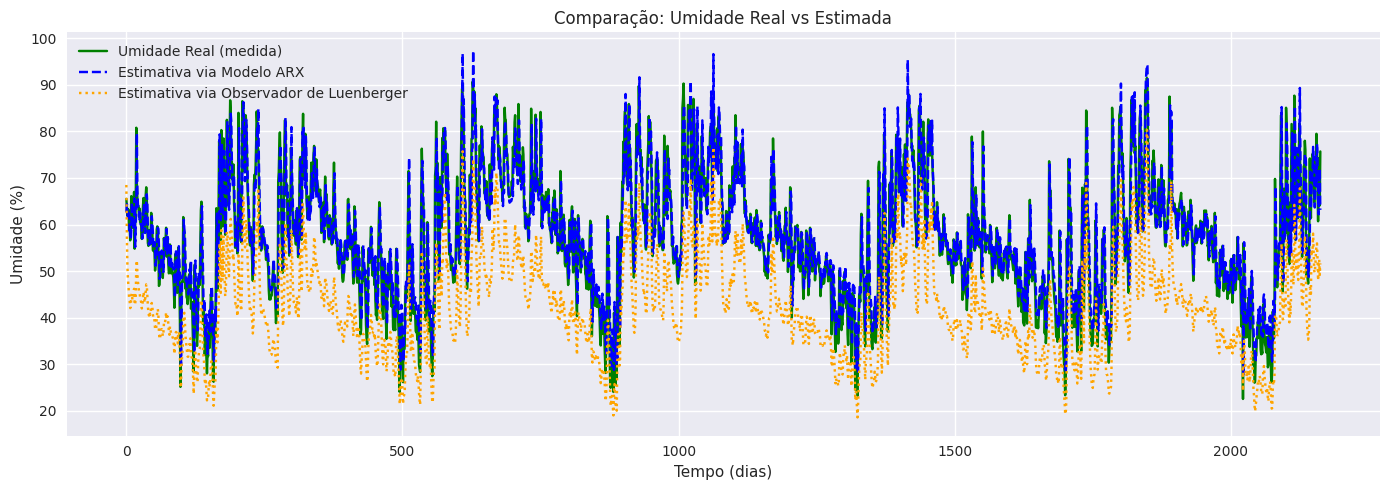

In [33]:
# Plotagem da compara√ß√£o geral entre valores reais e estimados pelo modelo ARX e pelo observador
plt.figure(figsize=(14,5))
plt.plot(y_test, label='Umidade Real (medida)', color='green')
plt.plot(y_pred_test, label='Estimativa via Modelo ARX', color='blue', linestyle='--')
plt.plot(x_est, label='Estimativa via Observador de Luenberger', color='orange', linestyle=':')
plt.title('Compara√ß√£o: Umidade Real vs Estimada')
plt.xlabel('Tempo (dias)')
plt.ylabel('Umidade (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### An√°lise dos Resultados

- O modelo ARX ajustado com m√≠nimos quadrados demonstrou bom desempenho na predi√ß√£o da umidade superficial do solo com base apenas na precipita√ß√£o e no hist√≥rico da pr√≥pria umidade.
- As m√©tricas (RMSE, MAE, R¬≤) indicam uma modelagem simples, por√©m √∫til, para estimativas di√°rias em regi√µes com regime de chuvas marcado, como Montes Claros/MG.
- O Observador de Luenberger foi capaz de estimar corretamente a din√¢mica interna do sistema (umidade do solo) mesmo com um erro inicial na estimativa, mostrando r√°pida converg√™ncia para o estado real.

---

### Limita√ß√µes do Modelo

1. **Simplicidade do modelo ARX**:
   - N√£o considera evapotranspira√ß√£o, infiltra√ß√£o profunda ou outras vari√°veis ambientais (ex: radia√ß√£o solar, tipo de solo).
   - Utiliza apenas uma defasagem da umidade; em solos mais complexos, pode haver mem√≥ria mais longa.

2. **Ru√≠do nos dados**:
   - A umidade do solo pode conter varia√ß√µes instrumentais e erros de medi√ß√£o.

3. **Esta√ß√£o seca e transi√ß√£o**:
   - O modelo tende a superestimar ou subestimar a umidade em per√≠odos de transi√ß√£o r√°pida (ex: in√≠cio/fim do per√≠odo chuvoso).


---

### Melhorias Futuras

- Incluir mais defasagens (ARX com ordem maior).
- Incorporar vari√°veis ambientais adicionais: temperatura, umidade do ar, radia√ß√£o solar.
- Aplicar filtros de suaviza√ß√£o ou modelos com regulariza√ß√£o (Ridge/Lasso).
- Testar modelos n√£o-lineares: redes neurais, √°rvores de decis√£o, LSTM.
- Considerar uso de modelos hidrol√≥gicos ou baseados em balan√ßo h√≠drico.

---

### Conclus√£o Geral

Este projeto demonstrou que √© poss√≠vel estimar de forma satisfat√≥ria a umidade superficial do solo a partir da precipita√ß√£o utilizando um modelo matem√°tico simples e interpret√°vel. A valida√ß√£o com um observador de Luenberger adiciona robustez √† estima√ß√£o, permitindo recuperar estados mesmo com medidas incompletas ou erros iniciais.

Esse tipo de abordagem pode ser √∫til para monitoramento agr√≠cola, planejamento de irriga√ß√£o e alerta para seca em regi√µes semi√°ridas como o Norte de Minas Gerais.